In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/root/project/VPR/AirGeoNet/')
import cv2
from pathlib import Path
import torch
import yaml
from torchmetrics import MetricCollection
from omegaconf import OmegaConf as OC
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pytorch_lightning import seed_everything

import maploc
from maploc.data import VPAirDataModule
from maploc.data.torch import unbatch_to_device
from maploc.module import GenericModule
from maploc.models.metrics import Location2DError, AngleError, LateralLongitudinalError
from maploc.evaluation.run import resolve_checkpoint_path
from maploc.evaluation.viz import plot_example_single

from maploc.models.voting import argmax_xyr, fuse_gps
from maploc.osm.viz import Colormap, plot_nodes
from maploc.utils.viz_2d import plot_images, features_to_RGB, save_plot, add_text
from maploc.utils.viz_localization import likelihood_overlay, plot_pose, plot_dense_rotations, add_circle_inset


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

torch.set_grad_enabled(False);
plt.rcParams.update({'figure.max_open_warning': 0})

/root/anaconda3/envs/AirGeoNet/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
conf = OC.load(Path(maploc.__file__).parent / 'conf/data/VPAir.yaml')
conf = OC.merge(conf, OC.create(yaml.full_load("""
loading:
    val: {batch_size: 1, num_workers: 0}
    train: ${.val}
# max_init_error_rotation: null  # to remove any prior on the rotation
# max_init_error: 64  # default: 20 (meters)
# add_map_mask: false  # remove to search in the entire tile
""")))
OC.resolve(conf)
dataset = VPAirDataModule(conf)
dataset.prepare_data()
dataset.setup()
sampler = None

[2024-12-09 11:59:29 maploc INFO] Loading the tile manager...


In [4]:
experiment = "/root/project/VPR/AirGeoNet/assets/modified_checkpoint.ckpt"
path = resolve_checkpoint_path(experiment)
print(path)
cfg = {'model': {"num_rotations": 32, "apply_map_prior": True}}
model = GenericModule.load_from_checkpoint(
    path, strict=False, find_best=not experiment.endswith('.ckpt'), cfg=cfg)
model = model.eval()#.cuda()

[2024-12-09 11:26:51 maploc INFO] Using checkpoint modified_checkpoint.ckpt from epoch 13 and step 70406.


/root/project/VPR/AirGeoNet/assets/modified_checkpoint.ckpt


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Seed set to 1


xyr_mean:  743.7074  391.8815    0.4509
[ CPUFloatType{1,3} ]
0 7.78 {'xy_max_error': 9.33, 'yaw_max_error': 0.0, 'directional_error': array([5.94, 7.2 ], dtype=float32)}
prob shape: (1024, 1024)
prob shape: (1024, 1024)
map_viz shape: (1024, 1024, 1)


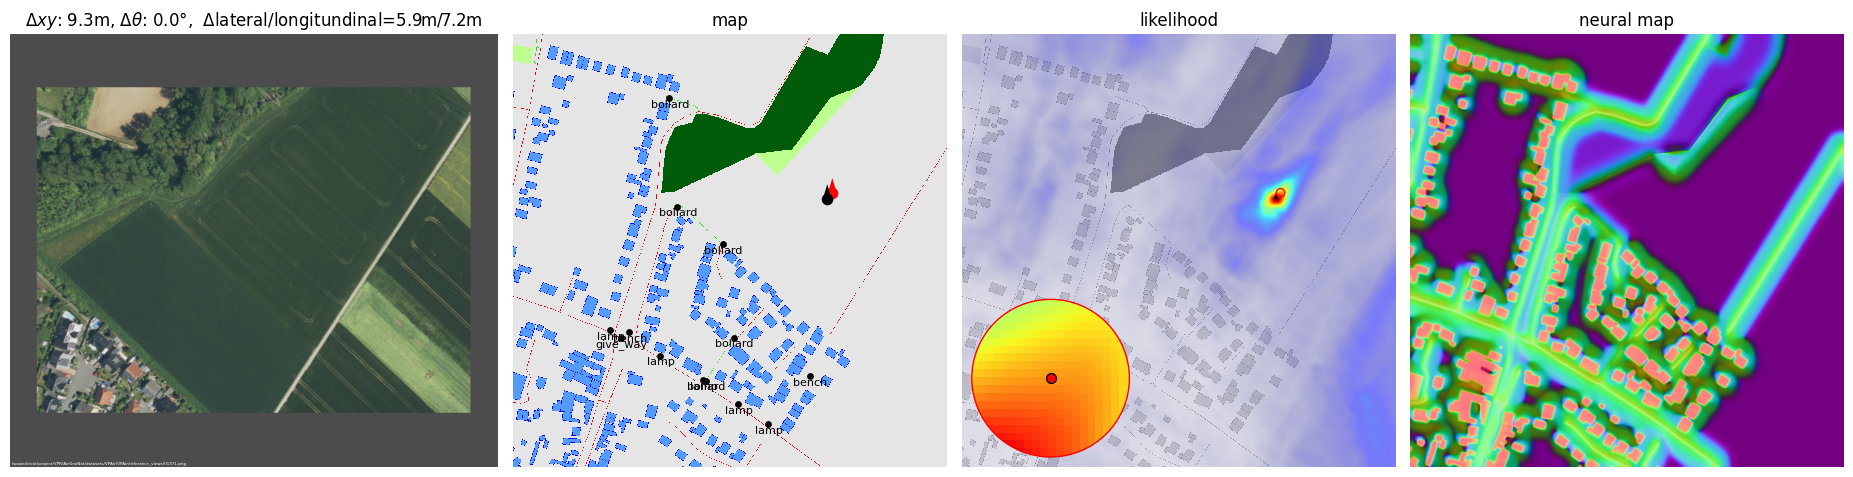

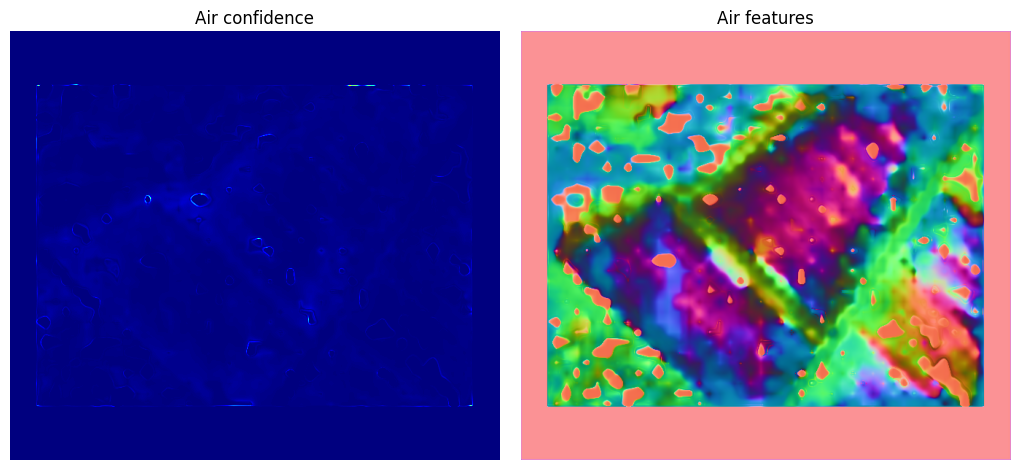

In [ ]:
out_dir = None
if out_dir is not None:
    !mkdir -p $out_dir/full
    
seed_everything(1) 
loader = dataset.dataloader("test", shuffle=sampler is None, sampler=sampler)
metrics = MetricCollection(model.model.metrics()).to(model.device)
metrics["directional_error"] = LateralLongitudinalError(model.cfg.data.pixel_per_meter)

for i, batch in zip(range(1), loader):
    lp_uvt = lp_uv = loss = results = pred = data = batch_ = None
    
    batch_ = model.transfer_batch_to_device(batch, model.device, i)
    pred = model(batch_)
    loss = model.model.loss(pred, batch_)
    results = metrics(pred, batch_)
    results.pop("xy_expectation_error")
    for k in list(results):
        if "recall" in k:
            results.pop(k)
    print(f'{i} {loss["total"].item():.2f}', {k: np.round(v.cpu().numpy(), 2) for k, v in results.items()})
#     if results["xy_max_error"] < 5:
#         continue

    pred = unbatch_to_device(pred)
    data = unbatch_to_device(batch)

    plot_example_single(i, model, pred, data, results, plot_air=True, out_dir=out_dir, show_dir_error=True)
